# 絵画データセットの探索的データ分析（EDA）

このノートブックでは、**画像ファイル名に基づいて作成されたデータセット**（`dataset_from_images.csv`）に対する包括的な探索的データ分析を実施します。

## データセットの説明

- **データソース**: `data/filtered_data/dataset_from_images.csv`
- **作成方法**: `paintings_images`ディレクトリにある画像ファイル名（Object_ID）をもとに、`raw_data/MetObjects.csv`から対応するデータを抽出
- **データ行数**: 5,396行（画像ファイル数に基づく）
- **データ列数**: 54列（MetObjects.csvの全列）

## 分析の目的

1. データの概要と品質の把握
2. 文化圏、年代、メディアなどの分布分析
3. アーティスト情報の分析
4. JSON形式データ（タグ、アーティスト、測定値）の解析
5. 画像データの分析
6. 変数間の関係性の探索


## セクション0: 環境設定とデータ読み込み


In [17]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from pathlib import Path
from collections import Counter

# 日本語フォントの設定（グラフで日本語を表示する場合）
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
sns.set_palette("husl")

# 警告の非表示
warnings.filterwarnings('ignore')

# 表示オプション
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

print("ライブラリの読み込み完了")


ライブラリの読み込み完了


In [18]:
# データの読み込み
# 画像ファイル名に基づいて作成されたデータセットを使用
data_path = Path("../data/filtered_data/dataset_from_images.csv")
df = pd.read_csv(data_path, low_memory=False)

print(f"データの形状: {df.shape}")
print(f"\nデータの読み込み完了: {len(df):,}行 × {len(df.columns)}列")
print(f"\nデータソース: {data_path}")
print("このデータセットは、paintings_imagesディレクトリにある画像ファイル名（Object_ID）")
print("をもとに、raw_data/MetObjects.csvから抽出されたデータです。")


データの形状: (5396, 54)

データの読み込み完了: 5,396行 × 54列

データソース: ..\data\filtered_data\dataset_from_images.csv
このデータセットは、paintings_imagesディレクトリにある画像ファイル名（Object_ID）
をもとに、raw_data/MetObjects.csvから抽出されたデータです。


In [19]:
# データの基本情報
print("=" * 60)
print("データの基本情報")
print("=" * 60)
df.info()


データの基本情報
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5396 entries, 0 to 5395
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Object Number            5396 non-null   object 
 1   Is Highlight             5396 non-null   bool   
 2   Is Timeline Work         5396 non-null   bool   
 3   Is Public Domain         5396 non-null   bool   
 4   Object ID                5396 non-null   int64  
 5   Gallery Number           706 non-null    float64
 6   Department               5396 non-null   object 
 7   AccessionYear            5391 non-null   float64
 8   Object Name              5389 non-null   object 
 9   Title                    3627 non-null   object 
 10  Culture                  3213 non-null   object 
 11  Period                   2454 non-null   object 
 12  Dynasty                  0 non-null      float64
 13  Reign                    0 non-null      float64
 14  Portfolio      

In [20]:
# データの最初の数行を表示
df.head()


,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,Period,Dynasty,Reign,Portfolio,Constituent ID,Artist Role,Artist Prefix,Artist Display Name,Artist Display Bio,Artist Suffix,Artist Alpha Sort,Artist Nationality,Artist Begin Date,Artist End Date,Artist Gender,Artist ULAN URL,Artist Wikidata URL,Object Date,Object Begin Date,Object End Date,Medium,Dimensions,Credit Line,Geography Type,City,State,County,Country,Region,Subregion,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
0,2009.224,False,True,True,35155,374.0,Arms and Armor,2009.0,Painting,"Guidobaldo II della Rovere, Duke of Urbino (1514–1574), With his Armor by Filippo Negroli",Italian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ca. 1580–85,1555,1610,Oil on copper,5 1/2 x 4 in. (14 x 10.2 cm); frame: 7 1/8 x 4 7/8 in. (18.1 x 12.5 cm),"Purchase, Arthur Ochs Sulzberger Gift, 2009",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paintings,NaN,http://www.metmuseum.org/art/collection/search/35155,https://www.wikidata.org/wiki/Q56042443,NaN,"Metropolitan Museum of Art, New York, NY",Armor|Men|Portraits,http://vocab.getty.edu/page/aat/300226591|http://vocab.getty.edu/page/aat/300025928|http://vocab...,https://www.wikidata.org/wiki/Q20793164|https://www.wikidata.org/wiki/Q8441|https://www.wikidata...
1,09.3,False,False,True,35968,NaN,Asian Art,1909.0,Pictorial map,清 佚名 台南地區荷蘭城堡|Forts Zeelandia and Provintia and the City of Tainan,China,NaN,NaN,NaN,NaN,3750,Artist,,Unidentified artist,"Chinese, active 19th century",,Unidentified artist,,,,NaN,NaN,NaN,19th century,1800,1899,Wall hanging; ink and color on deerskin,Image: 59 1/4 × 80 3/4 in. (150.5 × 205.1 cm)\r\nOverall with decorative borders: 68 5/8 × 90 1/...,"Gift of J. Pierpont Morgan, 1909",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paintings,NaN,http://www.metmuseum.org/art/collection/search/35968,https://www.wikidata.org/wiki/Q79003782,NaN,"Metropolitan Museum of Art, New York, NY",Maps|Houses|Cities|Boats|Ships,http://vocab.getty.edu/page/aat/300028094|http://vocab.getty.edu/page/aat/300005433|http://vocab...,https://www.wikidata.org/wiki/Q4006|https://www.wikidata.org/wiki/Q3947|https://www.wikidata.org...
2,12.37.135,False,False,False,35969,NaN,Asian Art,1912.0,Hanging scroll,NaN,China,Qing dynasty (1644–1911),NaN,NaN,NaN,1214,Artist,,Jin Zunnian,"Chinese, active early 18th century",,Jin Zunnian,Chinese,1700,1800,NaN,NaN,NaN,dated 1732,1732,1732,Hanging scroll; ink and color on silk,67 x 38 in. (170.2 x 96.5 cm),"Rogers Fund, 1912",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paintings,NaN,http://www.metmuseum.org/art/collection/search/35969,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
3,13.100.22,False,False,True,35970,NaN,Asian Art,1913.0,Hanging scroll,明 丁雲鵬 潯陽送客圖 軸|Song of the Lute,China,late Ming dynasty (1368–1644),NaN,NaN,NaN,1206,Artist,,Ding Yunpeng,"Chinese, 1547–ca. 1628",,Ding Yunpeng,Chinese,1547,1628,NaN,http://vocab.getty.edu/page/ulan/500125747,https://www.wikidata.org/wiki/Q376079,1585,1585,1585,Hanging scroll; ink and color on paper,Image: 55 5/8 x 18 1/8 in. (141.3 x 46 cm),"John Stewart Kennedy Fund, 1913",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paintings,NaN,http://www.metmuseum.org/art/collection/search/35970,https://www.wikidata.org/wiki/Q79003726,NaN,"Metropolitan Museum of Art, New York, NY",Mountains|Trees|Boats,http://vocab.getty.edu/page/aat/300008795|http://vocab.getty.edu/page/aat/300132410|http://vocab...,https://www.wikidata.org/wiki/Q8502|https://www.wikidata.org/wiki/Q10884|https://www.wikidata.or...
4,13.100.25,False,False,True,35971,NaN,Asian Art,1913.0,Hanging scroll,清 佚名 倣王翬 倣李成山水圖 軸|Landscape after Li Cheng,China,Qing dynasty (1644–1911),NaN,NaN,NaN,116363750,Artist|Artist,After|,Wang Hui|Unidentified artist,"Chinese, 1632–1717|",|,Wang Hui|U

## セクション1: データ概要


In [21]:
# データ形状の確認
print(f"行数: {df.shape[0]:,}")
print(f"列数: {df.shape[1]}")
print(f"\n列名一覧:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


行数: 5,396
列数: 54

列名一覧:
 1. Object Number
 2. Is Highlight
 3. Is Timeline Work
 4. Is Public Domain
 5. Object ID
 6. Gallery Number
 7. Department
 8. AccessionYear
 9. Object Name
10. Title
11. Culture
12. Period
13. Dynasty
14. Reign
15. Portfolio
16. Constituent ID
17. Artist Role
18. Artist Prefix
19. Artist Display Name
20. Artist Display Bio
21. Artist Suffix
22. Artist Alpha Sort
23. Artist Nationality
24. Artist Begin Date
25. Artist End Date
26. Artist Gender
27. Artist ULAN URL
28. Artist Wikidata URL
29. Object Date
30. Object Begin Date
31. Object End Date
32. Medium
33. Dimensions
34. Credit Line
35. Geography Type
36. City
37. State
38. County
39. Country
40. Region
41. Subregion
42. Locale
43. Locus
44. Excavation
45. River
46. Classification
47. Rights and Reproduction
48. Link Resource
49. Object Wikidata URL
50. Metadata Date
51. Repository
52. Tags
53. Tags AAT URL
54. Tags Wikidata URL


In [22]:
# データ型の確認
print("=" * 60)
print("データ型の分布")
print("=" * 60)
print(df.dtypes.value_counts())
print("\n各列のデータ型:")
print(df.dtypes)


データ型の分布
object     36
float64    12
bool        3
int64       3
Name: count, dtype: int64

各列のデータ型:
Object Number               object
Is Highlight                  bool
Is Timeline Work              bool
Is Public Domain              bool
Object ID                    int64
Gallery Number             float64
Department                  object
AccessionYear              float64
Object Name                 object
Title                       object
Culture                     object
Period                      object
Dynasty                    float64
Reign                      float64
Portfolio                  float64
Constituent ID              object
Artist Role                 object
Artist Prefix               object
Artist Display Name         object
Artist Display Bio          object
Artist Suffix               object
Artist Alpha Sort           object
Artist Nationality          object
Artist Begin Date           object
Artist End Date             object
Artist Gender            

In [23]:
# 欠損値の確認
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    '欠損数': missing_data,
    '欠損率(%)': missing_percent
})
missing_df = missing_df[missing_df['欠損数'] > 0].sort_values('欠損数', ascending=False)

print("=" * 60)
print(f"欠損値の概要（{len(missing_df)}列に欠損値あり）")
print("=" * 60)
print(missing_df.head(20))


欠損値の概要（42列に欠損値あり）
                          欠損数      欠損率(%)
Portfolio                5396  100.000000
Reign                    5396  100.000000
Dynasty                  5396  100.000000
State                    5396  100.000000
Locale                   5396  100.000000
Locus                    5396  100.000000
River                    5396  100.000000
Metadata Date            5396  100.000000
Excavation               5396  100.000000
Subregion                5396  100.000000
Rights and Reproduction  5395   99.981468
Region                   5395   99.981468
County                   5395   99.981468
City                     5387   99.833210
Geography Type           5379   99.684952
Country                  5373   99.573758
Artist Gender            5023   93.087472
Gallery Number           4690   86.916234
Period                   2942   54.521868
Culture                  2183   40.455893


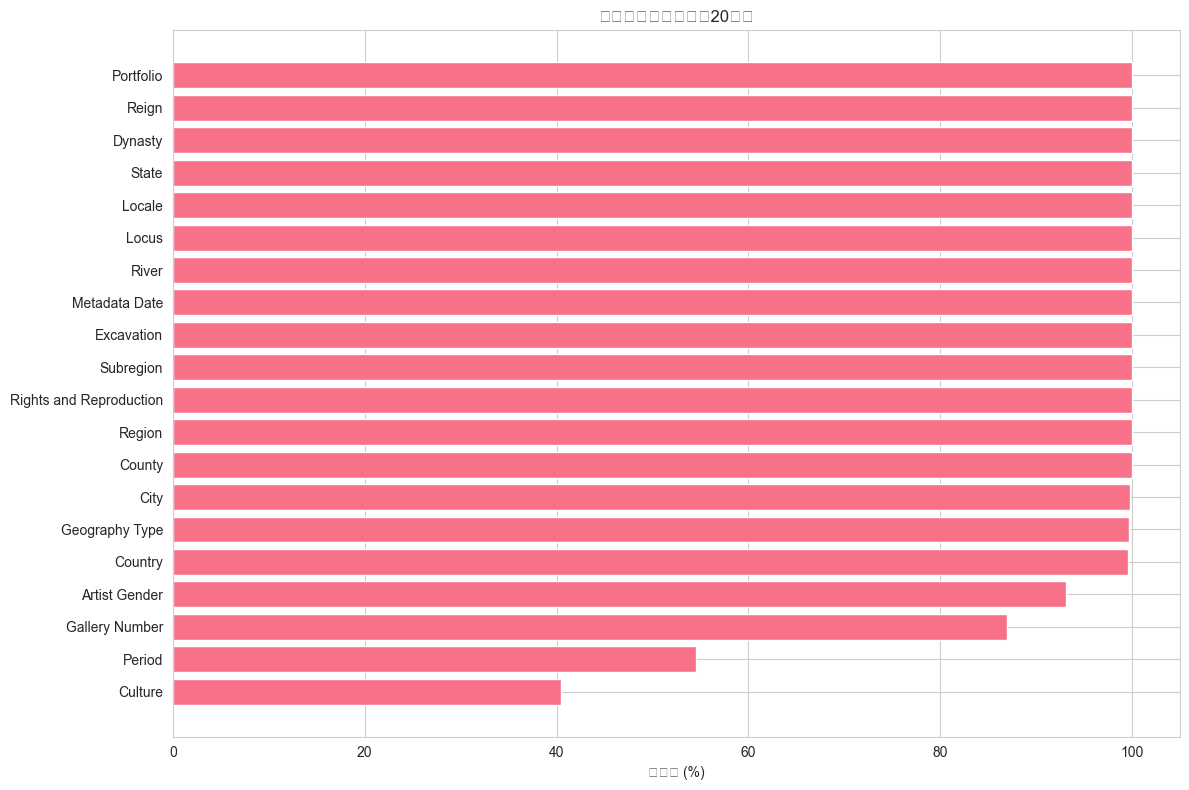

In [24]:
# 欠損値の可視化（上位20列）
plt.figure(figsize=(12, 8))
top_missing = missing_df.head(20)
plt.barh(range(len(top_missing)), top_missing['欠損率(%)'])
plt.yticks(range(len(top_missing)), top_missing.index)
plt.xlabel('欠損率 (%)')
plt.title('欠損値の割合（上位20列）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [25]:
# 数値列の基本統計量
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("=" * 60)
print("数値列の基本統計量")
print("=" * 60)
if len(numeric_cols) > 0:
    print(df[numeric_cols].describe())
else:
    print("数値列が見つかりませんでした")


数値列の基本統計量
           Object ID  Gallery Number  AccessionYear  Dynasty  Reign  \
count    5396.000000      706.000000    5391.000000      0.0    0.0   
mean   267430.765196      722.117564    1960.801892      NaN    NaN   
std    240129.259722      246.710165      37.230841      NaN    NaN   
min     35155.000000       10.000000    1871.000000      NaN    NaN   
25%     49459.750000      537.000000    1930.000000      NaN    NaN   
50%     76114.000000      810.000000    1958.000000      NaN    NaN   
75%    437376.500000      952.000000    1989.000000      NaN    NaN   
max    895426.000000      965.000000    2023.000000      NaN    NaN   

       Portfolio  Object Begin Date  Object End Date  State  Subregion  \
count        0.0        5396.000000      5396.000000    0.0        0.0   
mean         NaN        1622.224055      1676.639362    NaN        NaN   
std          NaN         222.732671       208.495886    NaN        NaN   
min          NaN           0.000000         0.000000  

## セクション2: 文化圏分析


In [26]:
# 文化圏（Culture）の分析
culture_counts = df['Culture'].value_counts()
culture_percent = (culture_counts / len(df)) * 100

print("=" * 60)
print(f"文化圏の概要（{len(culture_counts)}種類の文化圏）")
print("=" * 60)
print(f"欠損値: {df['Culture'].isnull().sum():,}件 ({df['Culture'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n上位20の文化圏:")
culture_top20 = pd.DataFrame({
    '作品数': culture_counts.head(20),
    '割合(%)': culture_percent.head(20)
})
print(culture_top20)


文化圏の概要（172種類の文化圏）
欠損値: 2,183件 (40.5%)

上位20の文化圏:
                                            作品数      割合(%)
Culture                                                   
Japan                                      1323  24.518162
China                                      1023  18.958488
India (Gujarat)                             199   3.687917
Tibet                                        82   1.519644
Korea                                        55   1.019274
India (Bengal) or Bangladesh                 35   0.648629
India                                        29   0.537435
India (Rajasthan, Mewar)                     24   0.444774
Nepal (Kathmandu Valley)                     22   0.407709
India (Rajasthan, Bikaner)                   19   0.352113
India, Madurai, Tamil Nadu                   17   0.315048
India (Madhya Pradesh, Malwa)                16   0.296516
India (Bihar or West Bengal)                 16   0.296516
India (Rajasthan)                            11   0.203855
China (

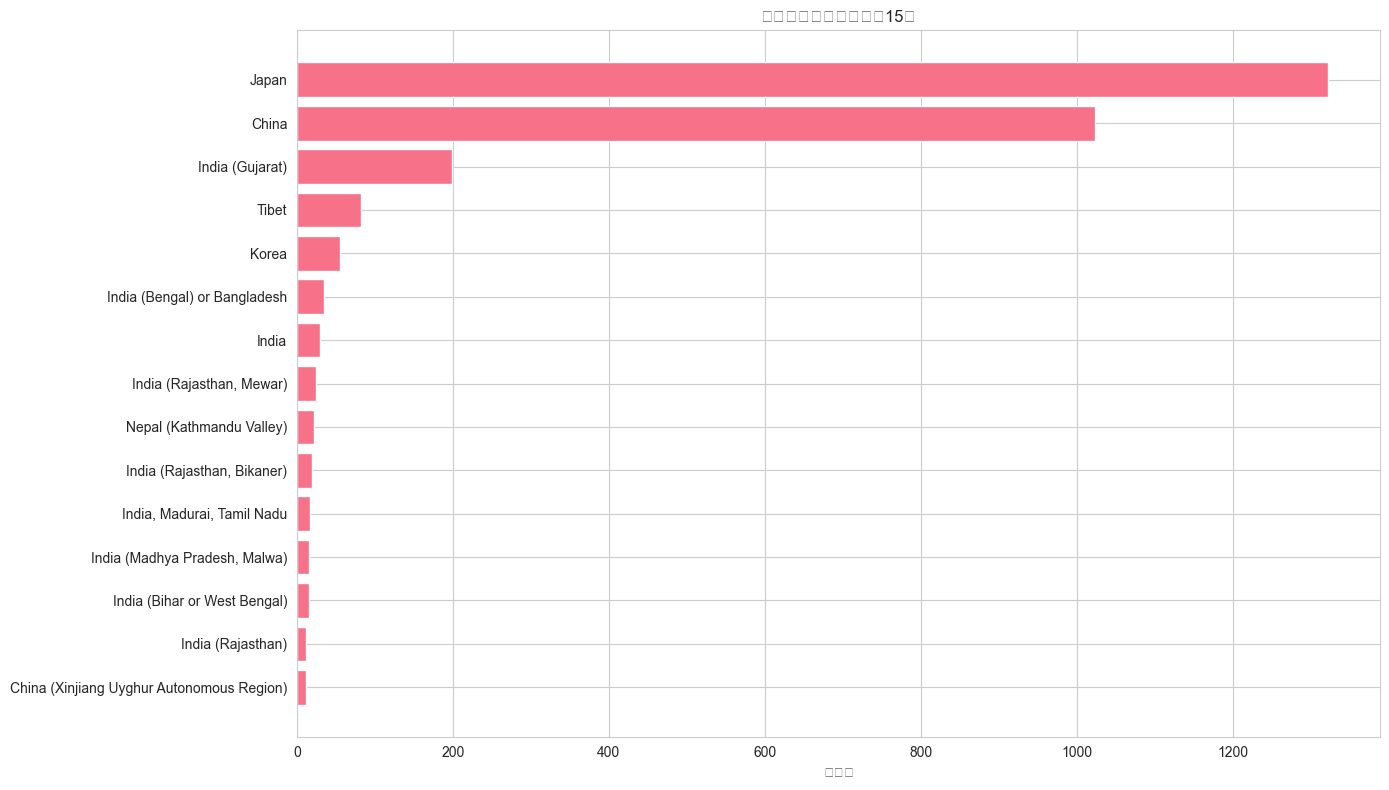

In [27]:
# 文化圏の分布を可視化（上位15）
plt.figure(figsize=(14, 8))
top_cultures = culture_counts.head(15)
plt.barh(range(len(top_cultures)), top_cultures.values)
plt.yticks(range(len(top_cultures)), top_cultures.index)
plt.xlabel('作品数')
plt.title('文化圏別作品数（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


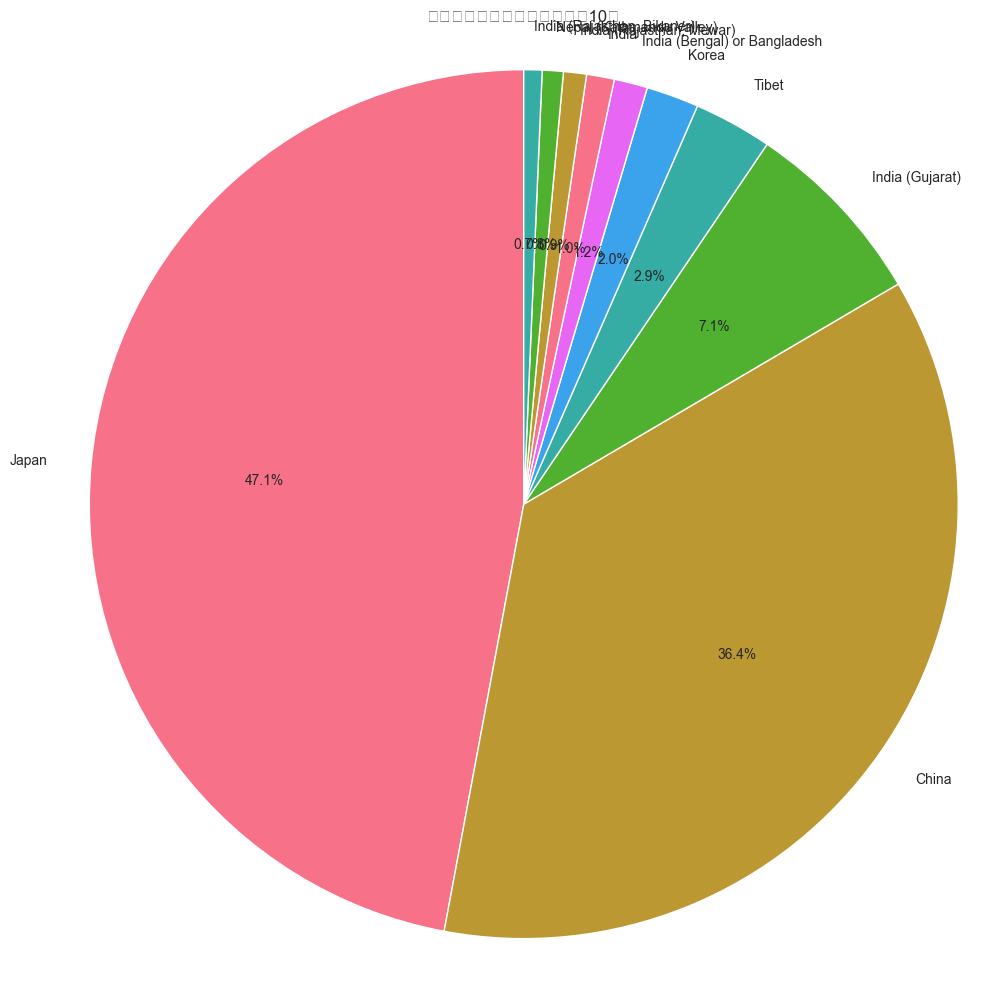

In [28]:
# 文化圏の割合を円グラフで表示（上位10）
plt.figure(figsize=(10, 10))
top_cultures_pie = culture_counts.head(10)
plt.pie(top_cultures_pie.values, labels=top_cultures_pie.index, autopct='%1.1f%%', startangle=90)
plt.title('文化圏別作品数の割合（上位10）')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [29]:
# 文化圏とDepartmentのクロス集計
culture_dept_cross = pd.crosstab(df['Culture'], df['Department'], margins=True)
print("=" * 60)
print("文化圏とDepartmentのクロス集計（上位20文化圏）")
print("=" * 60)
print(culture_dept_cross.loc[culture_counts.head(20).index].sort_values('All', ascending=False))


文化圏とDepartmentのクロス集計（上位20文化圏）
Department                                 Arms and Armor  \
Culture                                                     
Japan                                                   0   
China                                                   0   
India (Gujarat)                                         0   
Tibet                                                   0   
Korea                                                   0   
India (Bengal) or Bangladesh                            0   
India                                                   0   
India (Rajasthan, Mewar)                                0   
Nepal (Kathmandu Valley)                                0   
India (Rajasthan, Bikaner)                              0   
India, Madurai, Tamil Nadu                              0   
India (Madhya Pradesh, Malwa)                           0   
India (Bihar or West Bengal)                            0   
India (Rajasthan)                                      

## セクション3: 年代分析


In [30]:
# 年代データの確認
print("=" * 60)
print("年代データの概要")
print("=" * 60)

# Object_Begin_DateとObject_End_Dateの統計
print("\nObject_Begin_Date:")
print(f"  欠損値: {df['Object_Begin_Date'].isnull().sum():,}件")
print(f"  最小値: {df['Object_Begin_Date'].min()}")
print(f"  最大値: {df['Object_Begin_Date'].max()}")
print(f"  平均値: {df['Object_Begin_Date'].mean():.1f}")

print("\nObject_End_Date:")
print(f"  欠損値: {df['Object_End_Date'].isnull().sum():,}件")
print(f"  最小値: {df['Object_End_Date'].min()}")
print(f"  最大値: {df['Object_End_Date'].max()}")
print(f"  平均値: {df['Object_End_Date'].mean():.1f}")


年代データの概要

Object_Begin_Date:


KeyError: 'Object_Begin_Date'

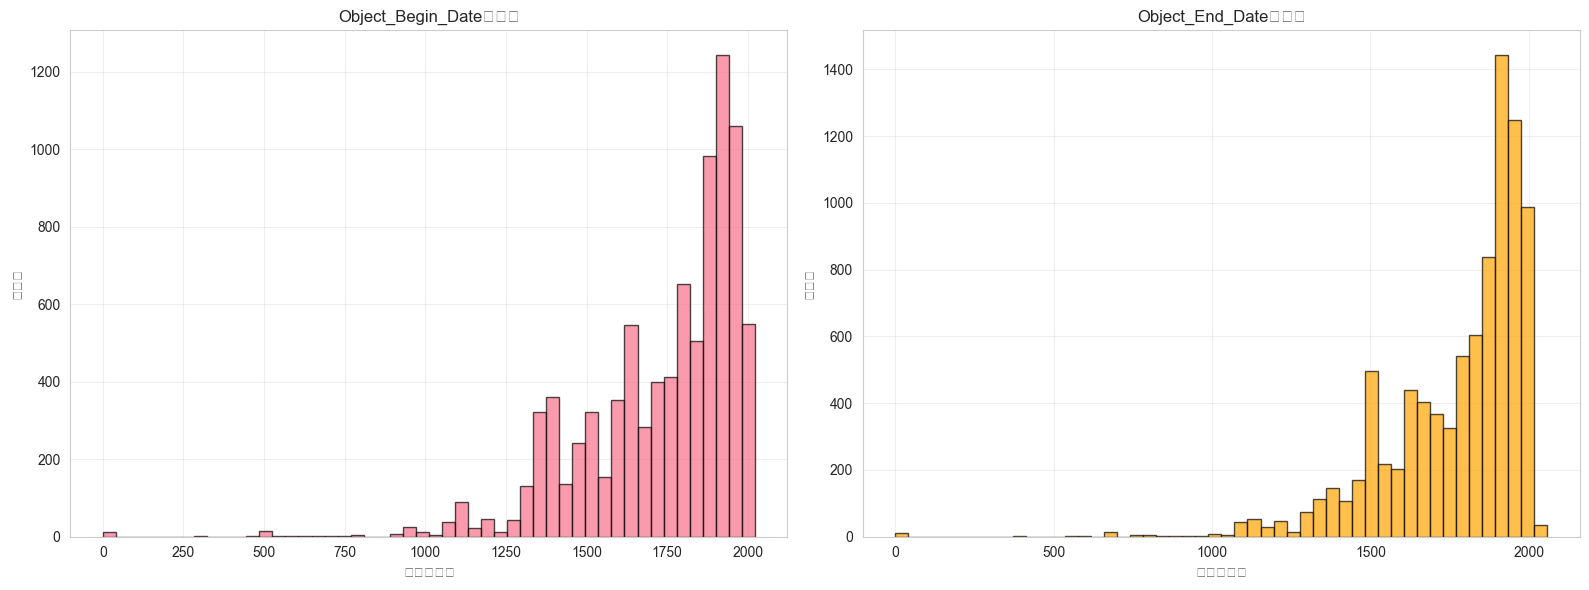

In [ ]:
# 作品制作年代の分布（ヒストグラム）
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Object_Begin_Dateの分布
valid_begin_dates = df['Object_Begin_Date'].dropna()
axes[0].hist(valid_begin_dates, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('制作開始年')
axes[0].set_ylabel('作品数')
axes[0].set_title('Object_Begin_Dateの分布')
axes[0].grid(True, alpha=0.3)

# Object_End_Dateの分布
valid_end_dates = df['Object_End_Date'].dropna()
axes[1].hist(valid_end_dates, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('制作終了年')
axes[1].set_ylabel('作品数')
axes[1].set_title('Object_End_Dateの分布')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# アーティストの活動期間の分析
print("=" * 60)
print("アーティスト活動期間の概要")
print("=" * 60)

print("\nArtist_Begin_Date:")
print(f"  欠損値: {df['Artist_Begin_Date'].isnull().sum():,}件")
if df['Artist_Begin_Date'].notna().any():
    print(f"  最小値: {df['Artist_Begin_Date'].min()}")
    print(f"  最大値: {df['Artist_Begin_Date'].max()}")

print("\nArtist_End_Date:")
print(f"  欠損値: {df['Artist_End_Date'].isnull().sum():,}件")
if df['Artist_End_Date'].notna().any():
    print(f"  最小値: {df['Artist_End_Date'].min()}")
    print(f"  最大値: {df['Artist_End_Date'].max()}")


アーティスト活動期間の概要

Artist_Begin_Date:
  欠損値: 984件


TypeError: '<=' not supported between instances of 'float' and 'str'

In [ ]:
# アーティスト活動期間の分布
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Artist_Begin_Dateの分布
valid_artist_begin = df['Artist_Begin_Date'].dropna()
if len(valid_artist_begin) > 0:
    axes[0].hist(valid_artist_begin, bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[0].set_xlabel('アーティスト活動開始年')
    axes[0].set_ylabel('人数')
    axes[0].set_title('Artist_Begin_Dateの分布')
    axes[0].grid(True, alpha=0.3)

# Artist_End_Dateの分布
valid_artist_end = df['Artist_End_Date'].dropna()
if len(valid_artist_end) > 0:
    axes[1].hist(valid_artist_end, bins=50, edgecolor='black', alpha=0.7, color='red')
    axes[1].set_xlabel('アーティスト活動終了年')
    axes[1].set_ylabel('人数')
    axes[1].set_title('Artist_End_Dateの分布')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## セクション4: メディア分析


In [ ]:
# メディア（Medium）の分析
medium_counts = df['Medium'].value_counts()
medium_percent = (medium_counts / len(df)) * 100

print("=" * 60)
print(f"メディアの概要（{len(medium_counts)}種類のメディア）")
print("=" * 60)
print(f"欠損値: {df['Medium'].isnull().sum():,}件 ({df['Medium'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n上位20のメディア:")
medium_top20 = pd.DataFrame({
    '作品数': medium_counts.head(20),
    '割合(%)': medium_percent.head(20)
})
print(medium_top20)


In [ ]:
# メディアの分布を可視化（上位15）
plt.figure(figsize=(14, 8))
top_mediums = medium_counts.head(15)
# 長いメディア名を短縮
labels = [m[:50] + '...' if len(m) > 50 else m for m in top_mediums.index]
plt.barh(range(len(top_mediums)), top_mediums.values)
plt.yticks(range(len(top_mediums)), labels)
plt.xlabel('作品数')
plt.title('メディア別作品数（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# メディアと文化圏のクロス集計（主要メディアのみ）
top_mediums_list = medium_counts.head(10).index.tolist()
medium_culture_cross = pd.crosstab(
    df[df['Medium'].isin(top_mediums_list)]['Medium'],
    df[df['Medium'].isin(top_mediums_list)]['Culture'],
    margins=True
)
print("=" * 60)
print("メディアと文化圏のクロス集計（主要メディア）")
print("=" * 60)
print(medium_culture_cross.loc[top_mediums_list].sort_values('All', ascending=False))


## セクション5: アーティスト分析


In [ ]:
# アーティスト名の分析
artist_counts = df['Artist_Display_Name'].value_counts()
artist_percent = (artist_counts / len(df)) * 100

print("=" * 60)
print(f"アーティストの概要（{len(artist_counts)}人のアーティスト）")
print("=" * 60)
print(f"欠損値: {df['Artist_Display_Name'].isnull().sum():,}件 ({df['Artist_Display_Name'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n上位20のアーティスト:")
artist_top20 = pd.DataFrame({
    '作品数': artist_counts.head(20),
    '割合(%)': artist_percent.head(20)
})
print(artist_top20)


In [ ]:
# アーティストの分布を可視化（上位15）
plt.figure(figsize=(14, 8))
top_artists = artist_counts.head(15)
# 長いアーティスト名を短縮
labels = [a[:40] + '...' if len(a) > 40 else a for a in top_artists.index]
plt.barh(range(len(top_artists)), top_artists.values)
plt.yticks(range(len(top_artists)), labels)
plt.xlabel('作品数')
plt.title('アーティスト別作品数（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# アーティストの国籍分析
nationality_counts = df['Artist_Nationality'].value_counts()
nationality_percent = (nationality_counts / len(df)) * 100

print("=" * 60)
print(f"アーティスト国籍の概要（{len(nationality_counts)}種類の国籍）")
print("=" * 60)
print(f"欠損値: {df['Artist_Nationality'].isnull().sum():,}件 ({df['Artist_Nationality'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n上位20の国籍:")
nationality_top20 = pd.DataFrame({
    '人数': nationality_counts.head(20),
    '割合(%)': nationality_percent.head(20)
})
print(nationality_top20)


In [ ]:
# アーティストの国籍分布を可視化（上位15）
plt.figure(figsize=(14, 8))
top_nationalities = nationality_counts.head(15)
plt.barh(range(len(top_nationalities)), top_nationalities.values)
plt.yticks(range(len(top_nationalities)), top_nationalities.index)
plt.xlabel('人数')
plt.title('アーティスト国籍別人数（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# アーティストの性別分析
gender_counts = df['Artist_Gender'].value_counts()
gender_percent = (gender_counts / len(df)) * 100

print("=" * 60)
print("アーティスト性別の概要")
print("=" * 60)
print(f"欠損値: {df['Artist_Gender'].isnull().sum():,}件 ({df['Artist_Gender'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n性別分布:")
gender_df = pd.DataFrame({
    '人数': gender_counts,
    '割合(%)': gender_percent
})
print(gender_df)

# 性別分布を可視化
plt.figure(figsize=(8, 6))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('アーティスト性別の分布')
plt.axis('equal')
plt.tight_layout()
plt.show()


## セクション6: Department分析


In [ ]:
# Departmentの分析
dept_counts = df['Department'].value_counts()
dept_percent = (dept_counts / len(df)) * 100

print("=" * 60)
print(f"Departmentの概要（{len(dept_counts)}種類のDepartment）")
print("=" * 60)
print(f"欠損値: {df['Department'].isnull().sum():,}件 ({df['Department'].isnull().sum() / len(df) * 100:.1f}%)")
print(f"\n全Department:")
dept_df = pd.DataFrame({
    '作品数': dept_counts,
    '割合(%)': dept_percent
})
print(dept_df)


In [ ]:
# Departmentの分布を可視化
plt.figure(figsize=(14, 8))
plt.barh(range(len(dept_counts)), dept_counts.values)
plt.yticks(range(len(dept_counts)), dept_counts.index)
plt.xlabel('作品数')
plt.title('Department別作品数')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Departmentと文化圏の関係（ヒートマップ）
dept_culture_cross = pd.crosstab(df['Department'], df['Culture'])
# 上位文化圏のみ抽出
top_cultures_list = culture_counts.head(15).index.tolist()
dept_culture_top = dept_culture_cross[top_cultures_list]

plt.figure(figsize=(16, 10))
sns.heatmap(dept_culture_top, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': '作品数'})
plt.title('Departmentと文化圏のクロス集計（上位15文化圏）')
plt.xlabel('文化圏')
plt.ylabel('Department')
plt.tight_layout()
plt.show()


## セクション7: タグ分析（JSON解析）


In [ ]:
# タグ列のJSON解析
def parse_tags(tags_str):
    """tags列をJSONとして解析してタグリストを返す"""
    if pd.isna(tags_str) or tags_str == '':
        return []
    try:
        if isinstance(tags_str, str):
            tags_data = json.loads(tags_str)
        else:
            tags_data = tags_str
        if isinstance(tags_data, list):
            # API形式の場合: [{"term": "...", ...}, ...]
            return [tag.get('term', '') for tag in tags_data if isinstance(tag, dict) and 'term' in tag]
        elif isinstance(tags_data, dict):
            # 単一タグの場合
            return [tags_data.get('term', '')] if 'term' in tags_data else []
        else:
            return []
    except (json.JSONDecodeError, TypeError):
        return []

# 全タグを抽出
print("タグ列の解析を開始...")
all_tags = []
tags_count = 0

for idx, tags_str in enumerate(df['tags']):
    if idx % 1000 == 0 and idx > 0:
        print(f"  処理中: {idx:,} / {len(df):,}行")
    tags_list = parse_tags(tags_str)
    all_tags.extend(tags_list)
    if tags_list:
        tags_count += 1

print(f"\n解析完了:")
print(f"  タグが存在する作品数: {tags_count:,}件 ({tags_count / len(df) * 100:.1f}%)")
print(f"  抽出されたタグの総数: {len(all_tags):,}個")
print(f"  ユニークなタグ数: {len(set(all_tags)):,}個")


In [ ]:
# 頻出タグの分析
tag_counter = Counter(all_tags)
tag_counts = pd.Series(dict(tag_counter.most_common()))

print("=" * 60)
print(f"頻出タグ（上位30）")
print("=" * 60)
tag_df = pd.DataFrame({
    '出現回数': tag_counts.head(30),
    '割合(%)': (tag_counts.head(30) / len(df) * 100).round(2)
})
print(tag_df)


In [ ]:
# 頻出タグの可視化（上位20）
plt.figure(figsize=(14, 8))
top_tags = tag_counts.head(20)
plt.barh(range(len(top_tags)), top_tags.values)
plt.yticks(range(len(top_tags)), top_tags.index)
plt.xlabel('出現回数')
plt.title('頻出タグ（上位20）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# 作品あたりのタグ数の分布
tags_per_artwork = []
for tags_str in df['tags']:
    tags_list = parse_tags(tags_str)
    tags_per_artwork.append(len(tags_list))

tags_per_artwork_series = pd.Series(tags_per_artwork)

print("=" * 60)
print("作品あたりのタグ数の統計")
print("=" * 60)
print(tags_per_artwork_series.describe())

plt.figure(figsize=(10, 6))
plt.hist(tags_per_artwork_series, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('タグ数')
plt.ylabel('作品数')
plt.title('作品あたりのタグ数の分布')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## セクション8: Constituents分析（JSON解析）


In [ ]:
# Constituents列のJSON解析
def parse_constituents(constituents_str):
    """constituents列をJSONとして解析してリストを返す"""
    if pd.isna(constituents_str) or constituents_str == '':
        return []
    try:
        if isinstance(constituents_str, str):
            constituents_data = json.loads(constituents_str)
        else:
            constituents_data = constituents_str
        if isinstance(constituents_data, list):
            return constituents_data
        elif isinstance(constituents_data, dict):
            return [constituents_data]
        else:
            return []
    except (json.JSONDecodeError, TypeError):
        return []

# Constituentsの分析
print("Constituents列の解析を開始...")
all_roles = []
all_genders = []
constituents_count = 0
constituents_per_artwork = []

for idx, constituents_str in enumerate(df['constituents']):
    if idx % 1000 == 0 and idx > 0:
        print(f"  処理中: {idx:,} / {len(df):,}行")
    constituents_list = parse_constituents(constituents_str)
    constituents_per_artwork.append(len(constituents_list))
    if constituents_list:
        constituents_count += 1
        for const in constituents_list:
            if isinstance(const, dict):
                if 'role' in const:
                    all_roles.append(const['role'])
                if 'gender' in const and const['gender']:
                    all_genders.append(const['gender'])

print(f"\n解析完了:")
print(f"  Constituentsが存在する作品数: {constituents_count:,}件 ({constituents_count / len(df) * 100:.1f}%)")
print(f"  抽出されたロール数: {len(all_roles):,}個")
print(f"  抽出された性別情報数: {len(all_genders):,}個")


In [ ]:
# アーティストロールの分析
role_counter = Counter(all_roles)
role_counts = pd.Series(dict(role_counter.most_common()))

print("=" * 60)
print(f"アーティストロールの分布（上位20）")
print("=" * 60)
role_df = pd.DataFrame({
    '出現回数': role_counts.head(20),
    '割合(%)': (role_counts.head(20) / len(all_roles) * 100).round(2) if len(all_roles) > 0 else 0
})
print(role_df)

# ロールの可視化
plt.figure(figsize=(14, 8))
top_roles = role_counts.head(15)
plt.barh(range(len(top_roles)), top_roles.values)
plt.yticks(range(len(top_roles)), top_roles.index)
plt.xlabel('出現回数')
plt.title('アーティストロールの分布（上位15）')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Constituents内の性別分布
if len(all_genders) > 0:
    gender_counter = Counter(all_genders)
    gender_counts_const = pd.Series(dict(gender_counter.most_common()))
    
    print("=" * 60)
    print("Constituents内の性別分布")
    print("=" * 60)
    gender_const_df = pd.DataFrame({
        '人数': gender_counts_const,
        '割合(%)': (gender_counts_const / len(all_genders) * 100).round(2)
    })
    print(gender_const_df)
    
    # 性別分布を可視化
    plt.figure(figsize=(8, 6))
    plt.pie(gender_counts_const.values, labels=gender_counts_const.index, autopct='%1.1f%%', startangle=90)
    plt.title('Constituents内の性別分布')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("性別情報が見つかりませんでした")


In [ ]:
# 作品あたりのConstituents数の分布
constituents_per_artwork_series = pd.Series(constituents_per_artwork)

print("=" * 60)
print("作品あたりのConstituents数の統計")
print("=" * 60)
print(constituents_per_artwork_series.describe())

plt.figure(figsize=(10, 6))
plt.hist(constituents_per_artwork_series, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Constituents数')
plt.ylabel('作品数')
plt.title('作品あたりのConstituents数の分布')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## セクション9: 測定値分析（JSON解析）


In [ ]:
# Measurements列のJSON解析
def parse_measurements(measurements_str):
    """measurements列をJSONとして解析してリストを返す"""
    if pd.isna(measurements_str) or measurements_str == '':
        return []
    try:
        if isinstance(measurements_str, str):
            measurements_data = json.loads(measurements_str)
        else:
            measurements_data = measurements_str
        if isinstance(measurements_data, list):
            return measurements_data
        elif isinstance(measurements_data, dict):
            return [measurements_data]
        else:
            return []
    except (json.JSONDecodeError, TypeError):
        return []

def extract_dimensions(measurements_data):
    """measurementsデータからHeightとWidthを抽出"""
    heights = []
    widths = []
    depths = []
    
    for measure in measurements_data:
        if isinstance(measure, dict) and 'elementMeasurements' in measure:
            elem_measure = measure['elementMeasurements']
            if isinstance(elem_measure, dict):
                if 'Height' in elem_measure:
                    try:
                        heights.append(float(elem_measure['Height']))
                    except (ValueError, TypeError):
                        pass
                if 'Width' in elem_measure:
                    try:
                        widths.append(float(elem_measure['Width']))
                    except (ValueError, TypeError):
                        pass
                if 'Depth' in elem_measure:
                    try:
                        depths.append(float(elem_measure['Depth']))
                    except (ValueError, TypeError):
                        pass
    
    return heights, widths, depths

# Measurementsの分析
print("Measurements列の解析を開始...")
all_heights = []
all_widths = []
all_depths = []
measurements_count = 0

for idx, measurements_str in enumerate(df['measurements']):
    if idx % 1000 == 0 and idx > 0:
        print(f"  処理中: {idx:,} / {len(df):,}行")
    measurements_data = parse_measurements(measurements_str)
    if measurements_data:
        measurements_count += 1
        heights, widths, depths = extract_dimensions(measurements_data)
        all_heights.extend(heights)
        all_widths.extend(widths)
        all_depths.extend(depths)

print(f"\n解析完了:")
print(f"  Measurementsが存在する作品数: {measurements_count:,}件 ({measurements_count / len(df) * 100:.1f}%)")
print(f"  抽出されたHeight値: {len(all_heights):,}個")
print(f"  抽出されたWidth値: {len(all_widths):,}個")
print(f"  抽出されたDepth値: {len(all_depths):,}個")


In [ ]:
# 作品サイズの分析
if len(all_heights) > 0 and len(all_widths) > 0:
    heights_series = pd.Series(all_heights)
    widths_series = pd.Series(all_widths)
    
    print("=" * 60)
    print("作品サイズの統計（cm単位）")
    print("=" * 60)
    print("\nHeight（高さ）:")
    print(heights_series.describe())
    print("\nWidth（幅）:")
    print(widths_series.describe())
    
    # サイズの分布を可視化
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Heightの分布
    axes[0].hist(heights_series, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Height (cm)')
    axes[0].set_ylabel('作品数')
    axes[0].set_title('作品の高さ（Height）の分布')
    axes[0].grid(True, alpha=0.3)
    
    # Widthの分布
    axes[1].hist(widths_series, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1].set_xlabel('Width (cm)')
    axes[1].set_ylabel('作品数')
    axes[1].set_title('作品の幅（Width）の分布')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("サイズデータが見つかりませんでした")


In [ ]:
# アスペクト比の分析
if len(all_heights) > 0 and len(all_widths) > 0:
    # HeightとWidthのペアを作成（同じインデックスのものをペアにする）
    min_len = min(len(all_heights), len(all_widths))
    heights_paired = all_heights[:min_len]
    widths_paired = all_widths[:min_len]
    
    # アスペクト比を計算（幅/高さ）
    aspect_ratios = [w/h if h > 0 else np.nan for h, w in zip(heights_paired, widths_paired)]
    aspect_ratios_series = pd.Series(aspect_ratios).dropna()
    
    print("=" * 60)
    print("アスペクト比（幅/高さ）の統計")
    print("=" * 60)
    print(aspect_ratios_series.describe())
    
    # アスペクト比の分布を可視化
    plt.figure(figsize=(10, 6))
    plt.hist(aspect_ratios_series, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('アスペクト比（幅/高さ）')
    plt.ylabel('作品数')
    plt.title('作品のアスペクト比の分布')
    plt.axvline(1.0, color='red', linestyle='--', label='正方形 (1:1)')
    plt.axvline(1.5, color='orange', linestyle='--', label='3:2 (1.5:1)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("アスペクト比を計算するためのデータが不足しています")


## セクション10: 画像データ分析


In [ ]:
# 画像ダウンロード状況の分析
image_downloaded_counts = df['image_downloaded'].value_counts()
image_downloaded_percent = (image_downloaded_counts / len(df)) * 100

print("=" * 60)
print("画像ダウンロード状況")
print("=" * 60)
print(f"画像ダウンロード済み: {image_downloaded_counts.get(True, 0):,}件 ({image_downloaded_percent.get(True, 0):.1f}%)")
print(f"画像ダウンロード未済: {image_downloaded_counts.get(False, 0):,}件 ({image_downloaded_percent.get(False, 0):.1f}%)")

# 可視化
plt.figure(figsize=(8, 6))
plt.pie(image_downloaded_counts.values, labels=['ダウンロード済み' if k else '未ダウンロード' for k in image_downloaded_counts.index], 
        autopct='%1.1f%%', startangle=90)
plt.title('画像ダウンロード状況')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
# primaryImageSmallの有無
primary_image_small_has = df['primaryImageSmall'].notna().sum()
primary_image_small_percent = (primary_image_small_has / len(df)) * 100

print("=" * 60)
print("primaryImageSmallの有無")
print("=" * 60)
print(f"primaryImageSmallあり: {primary_image_small_has:,}件 ({primary_image_small_percent:.1f}%)")
print(f"primaryImageSmallなし: {len(df) - primary_image_small_has:,}件 ({100 - primary_image_small_percent:.1f}%)")

# additionalImagesの有無
additional_images_has = df['additionalImages'].notna().sum()
additional_images_percent = (additional_images_has / len(df)) * 100

print(f"\nadditionalImagesあり: {additional_images_has:,}件 ({additional_images_percent:.1f}%)")
print(f"additionalImagesなし: {len(df) - additional_images_has:,}件 ({100 - additional_images_percent:.1f}%)")


In [ ]:
# 画像URLの形式分析（primaryImageSmallのサンプル）
sample_image_urls = df['primaryImageSmall'].dropna().head(10)
print("=" * 60)
print("画像URLのサンプル（primaryImageSmall）")
print("=" * 60)
for i, url in enumerate(sample_image_urls, 1):
    print(f"{i:2d}. {url}")


## セクション11: 総合分析と洞察


In [ ]:
# 主要変数間の相関分析（数値列のみ）
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# 重要な数値列を選択
important_numeric_cols = ['Object_ID', 'AccessionYear', 'Object_Begin_Date', 'Object_End_Date', 
                          'Artist_Begin_Date', 'Artist_End_Date', 'Gallery_Number']
available_numeric_cols = [col for col in important_numeric_cols if col in numeric_cols]

if len(available_numeric_cols) > 1:
    correlation_matrix = df[available_numeric_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('主要数値変数間の相関行列')
    plt.tight_layout()
    plt.show()
    
    print("=" * 60)
    print("主要数値変数間の相関行列")
    print("=" * 60)
    print(correlation_matrix)
else:
    print("相関分析に十分な数値列がありません")


## 重要な洞察のまとめ

以下に、このEDAで得られた主要な洞察をまとめます。


In [ ]:
# データ品質の評価
print("=" * 60)
print("データ品質の評価")
print("=" * 60)

# 主要列の欠損率
key_columns = ['Culture', 'Medium', 'Artist_Display_Name', 'Department', 
               'Object_Begin_Date', 'Object_End_Date', 'tags', 'constituents', 'measurements']

quality_report = []
for col in key_columns:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_percent = (missing_count / len(df)) * 100
        quality_report.append({
            '列名': col,
            '欠損数': missing_count,
            '欠損率(%)': f"{missing_percent:.1f}%",
            'データ品質': '良好' if missing_percent < 10 else '要改善' if missing_percent < 50 else '悪い'
        })

quality_df = pd.DataFrame(quality_report)
print(quality_df.to_string(index=False))


## 今後の分析に向けた提案

1. **機械学習モデル構築**: 文化圏、年代、メディアなどを特徴量として使用した分類モデルの構築
2. **時系列分析**: 年代別の作品スタイルの変化を追跡
3. **クラスタリング分析**: 作品の特徴に基づいたクラスタリング
4. **ネットワーク分析**: アーティスト間の関係性や影響関係の分析
5. **地理的分析**: 文化圏と地域の関係性の詳細分析

---

**分析完了**
